### 🚀 For an interactive experience, head over to our [demo platform](https://var.vision/demo) and dive right in! 🌟

In [2]:
################## 1. Download checkpoints and build models
import os
if os.path.exists('/content/VAR'): os.chdir('/content/VAR')
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

# we recommend using imagenet-512-d36 model to do the in-painting & out-painting & class-condition editing task
MODEL_DEPTH = 16    # TODO: =====> please specify MODEL_DEPTH <=====

assert MODEL_DEPTH in {16, 20, 24, 30, 36}


# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
FOR_512_px = MODEL_DEPTH == 36
if FOR_512_px:
    patch_nums = (1, 2, 3, 4, 6, 9, 13, 18, 24, 32)
else:
    patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae, var = build_vae_var(
    V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
    device=device, patch_nums=patch_nums,
    num_classes=1000, depth=MODEL_DEPTH, shared_aln=FOR_512_px,
)

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'preparation finished.')


[constructor]  ==== flash_if_available=True (0/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))



[init_weights] VAR with init_std=0.0180422


/tmp/ipykernel_2768452/3129065592.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
/tmp/ipyker

preparation finished.


In [3]:
################## 2. Define some helper functions for zero-shot editing

from typing import List, Optional, Union

import torch
import torch.nn.functional as F
from models.var import AdaLNSelfAttn, sample_with_top_k_top_p_, gumbel_softmax_with_rng


def get_edit_mask(patch_nums: List[int], y0: float, x0: float, y1: float, x1: float, device, inpainting: bool = True) -> torch.Tensor:
    ph, pw = patch_nums[-1], patch_nums[-1]
    edit_mask = torch.zeros(ph, pw, device=device)
    edit_mask[round(y0 * ph):round(y1 * ph), round(x0 * pw):round(x1 * pw)] = 1 # outpainting mode: center would be gt
    if inpainting:
        edit_mask = 1 - edit_mask   # inpainting mode: center would be model pred
    return edit_mask    # a binary mask, 1 for keeping the tokens of the image to be edited; 0 for generating new tokens (by VAR)


# overwrite the function of 'VAR::autoregressive_infer_cfg'
def autoregressive_infer_cfg_with_mask(
    self, B: int, label_B: Optional[Union[int, torch.LongTensor]],
    g_seed: Optional[int] = None, cfg=1.5, top_k=0, top_p=0.0,
    more_smooth=False,
    input_img_tokens: Optional[List[torch.Tensor]] = None, edit_mask: Optional[torch.Tensor] = None,
) -> torch.Tensor:   # returns reconstructed image (B, 3, H, W) in [0, 1]
    """
    only used for inference, on autoregressive mode
    :param B: batch size
    :param label_B: imagenet label; if None, randomly sampled
    :param g_seed: random seed
    :param cfg: classifier-free guidance ratio
    :param top_k: top-k sampling
    :param top_p: top-p sampling
    :param more_smooth: smoothing the pred using gumbel softmax; only used in visualization, not used in FID/IS benchmarking
    :param input_img_tokens: (optional, only for zero-shot edit tasks) tokens of the image to be edited
    :param edit_mask: (optional, only for zero-shot edit tasks) binary mask, 1 for keeping given tokens; 0 for generating new tokens
    :return: if returns_vemb: list of embedding h_BChw := vae_embed(idx_Bl), else: list of idx_Bl
    """
    if g_seed is None: rng = None
    else: self.rng.manual_seed(g_seed); rng = self.rng

    if label_B is None:
        label_B = torch.multinomial(self.uniform_prob, num_samples=B, replacement=True, generator=rng).reshape(B)
    elif isinstance(label_B, int):
        label_B = torch.full((B,), fill_value=self.num_classes if label_B < 0 else label_B, device=self.lvl_1L.device)

    sos = cond_BD = self.class_emb(torch.cat((label_B, torch.full_like(label_B, fill_value=self.num_classes)), dim=0))

    lvl_pos = self.lvl_embed(self.lvl_1L) + self.pos_1LC
    next_token_map = sos.unsqueeze(1).expand(2 * B, self.first_l, -1) + self.pos_start.expand(2 * B, self.first_l, -1) + lvl_pos[:, :self.first_l]

    cur_L = 0
    f_hat = sos.new_zeros(B, self.Cvae, self.patch_nums[-1], self.patch_nums[-1])

    for b in self.blocks: b.attn.kv_caching(True)
    for si, pn in enumerate(self.patch_nums):   # si: i-th segment
        ratio = si / self.num_stages_minus_1
        # last_L = cur_L
        cur_L += pn*pn
        # assert self.attn_bias_for_masking[:, :, last_L:cur_L, :cur_L].sum() == 0, f'AR with {(self.attn_bias_for_masking[:, :, last_L:cur_L, :cur_L] != 0).sum()} / {self.attn_bias_for_masking[:, :, last_L:cur_L, :cur_L].numel()} mask item'
        cond_BD_or_gss = self.shared_ada_lin(cond_BD)
        x = next_token_map
        AdaLNSelfAttn.forward
        for b in self.blocks:
            x = b(x=x, cond_BD=cond_BD_or_gss, attn_bias=None)
        logits_BlV = self.get_logits(x, cond_BD)

        t = cfg * ratio
        logits_BlV = (1+t) * logits_BlV[:B] - t * logits_BlV[B:]

        idx_Bl = sample_with_top_k_top_p_(logits_BlV, rng=rng, top_k=top_k, top_p=top_p, num_samples=1)[:, :, 0]
        if not more_smooth: # this is the default case
            h_BChw = self.vae_quant_proxy[0].embedding(idx_Bl)   # B, l, Cvae
        else:   # not used when evaluating FID/IS/Precision/Recall
            gum_t = max(0.27 * (1 - ratio * 0.95), 0.005)   # refer to mask-git
            h_BChw = gumbel_softmax_with_rng(logits_BlV.mul(1 + ratio), tau=gum_t, hard=False, dim=-1, rng=rng) @ self.vae_quant_proxy[0].embedding.weight.unsqueeze(0)

        h_BChw = h_BChw.transpose_(1, 2).reshape(B, self.Cvae, pn, pn)
        if edit_mask is not None:
            gt_BChw = self.vae_quant_proxy[0].embedding(input_img_tokens[si]).transpose_(1, 2).reshape(B, self.Cvae, pn, pn)
            h_BChw = replace_embedding(edit_mask, h_BChw, gt_BChw, pn, pn)

        f_hat, next_token_map = self.vae_quant_proxy[0].get_next_autoregressive_input(si, len(self.patch_nums), f_hat, h_BChw)
        if si != self.num_stages_minus_1:   # prepare for next stage
            next_token_map = next_token_map.view(B, self.Cvae, -1).transpose(1, 2)
            next_token_map = self.word_embed(next_token_map) + lvl_pos[:, cur_L:cur_L + self.patch_nums[si+1] ** 2]
            next_token_map = next_token_map.repeat(2, 1, 1)   # double the batch sizes due to CFG

    for b in self.blocks: b.attn.kv_caching(False)
    return self.vae_proxy[0].fhat_to_img(f_hat).add_(1).mul_(0.5)


def replace_embedding(edit_mask: torch.Tensor, h_BChw: torch.Tensor, gt_BChw: torch.Tensor, ph: int, pw: int) -> torch.Tensor:
    B = h_BChw.shape[0]
    h, w = edit_mask.shape[-2:]
    if edit_mask.ndim == 2:
        edit_mask = edit_mask.unsqueeze(0).expand(B, h, w)

    force_gt_B1hw = F.interpolate(edit_mask.unsqueeze(1).to(dtype=torch.float, device=gt_BChw.device), size=(ph, pw), mode='bilinear', align_corners=False).gt(0.5).int()
    if ph * pw <= 3: force_gt_B1hw.fill_(1)
    return gt_BChw * force_gt_B1hw + h_BChw * (1 - force_gt_B1hw)


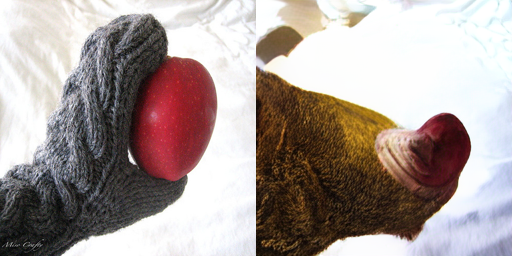

In [8]:
############################# 3. Sample with classifier-free guidance

# set args
img_to_be_edited = '/home/woody/iwi1/iwi1106h/data/imagenet/val/n03775071/ILSVRC2012_val_00013118.JPEG'

# edit to class label, if it was set to 0-999, it's an class condition editing task
# if it was set to 1000, it's an in-painting task

class_label = 1000  #@param {type:"raw"}
seed = 0 #@param {type:"number"}
cfg = 4 #@param {type:"slider", min:1, max:10, step:0.1}
more_smooth = False # True for more smooth output

# seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

# load the image to be edited
from utils.data import pil_loader, normalize_01_into_pm1
from torchvision.transforms import transforms
from PIL import Image
# resize the input image according to the model
if MODEL_DEPTH == 36:
    pil_img = pil_loader(img_to_be_edited).resize((512, 512))
else:
    pil_img = pil_loader(img_to_be_edited).resize((256, 256))
input_img = normalize_01_into_pm1(transforms.ToTensor()(pil_img)).unsqueeze(0).to(device=device)
input_img_tokens = vae.img_to_idxBl(input_img, var.patch_nums)

# zero-shot edit
# The inpainting parameter controls whether the task is inpainting or outpainting
edit_mask = get_edit_mask(
    var.patch_nums,
    y0=0.1, x0=0.1,
    y1=0.8, x1=0.8,
    device=device, inpainting=True,
)
B = 1
label_B: torch.LongTensor = torch.tensor([class_label], device=device)
with torch.inference_mode():
    with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
        recon_B3HW = autoregressive_infer_cfg_with_mask(
            var,
            B=B, label_B=label_B, cfg=3, top_k=900, top_p=0.95, g_seed=0, more_smooth=True,
            input_img_tokens=input_img_tokens, edit_mask=edit_mask
        )

chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
chw = chw.permute(1, 2, 0).mul(255).cpu().numpy()
chw = PImage.fromarray(chw.astype(np.uint8))

combined = Image.new('RGB', (pil_img.width * 2, pil_img.height))
combined.paste(pil_img, (0, 0))
combined.paste(chw, (pil_img.width, 0))
combined


var.patch_nums